# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Results](#Results)
  * [Visualization](#Visualization)
* [Discussion](#Discussion)

# Introduction

In this notebook, the one-vs-one classification scenario is considered with the development set.

A test harness is prepared for several models that showed promise in some previous explorations. FRILL embeddings are provided as development data and the results are visualized.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from time import time
from tqdm.notebook import tqdm

# faster pandas/sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()

# typing
from typing import Callable, Tuple
from sklearn.base import BaseEstimator

# metrics
from sklearn.metrics import balanced_accuracy_score, f1_score

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# hide warnings
import warnings

# warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.36 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

# Location where the FRILL module is stored locally
LOCAL_FRILL = "../../../FRILL/"

_ = gc_collect()

time: 129 ms


# Data loading

In [5]:
# uncomment lines to undersample data
data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
# data = data.sample(frac=0.02, random_state=SEED).sort_index()
labels = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather").set_index("id")
# labels = labels.loc[data.index].drop(columns="index").sort_index()
all(data.index == labels.index)
# data = data.head(100)
# labels = labels.head(100)

True

time: 283 ms


In [6]:
data.head(1)
data.info()
labels.info()
labels.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   index           17703 non-null  int64   
 1   file            17703 non-null  object  
 2   source          17703 non-null  category
 3   length          17703 non-null  category
 4   speaker_id      17703 non-null  category
 5   speaker_gender  17703 non-null  category
 6   lang1           17703 non-null  category
 7   emo             17703 non-null  category
 8   valence         17703 non-null  int8    
 9   neg             17703 non-null  bool    
 10  neu             17703 non-null  bool    
 11  pos             17703 non-null  bool    
dtypes: bool(3), category(6), int64(1), int8(1), object(1)
memory usage: 650.1+ KB


,index,file,source,length,speaker_id,speaker_gender,lang1,emo,valence,neg,neu,pos
id,,,,,,,,,,,,
0,0,00000+aesdd+aesdd.1+f+ang+-1+ell+el-gr.wav,aesdd,medium,aesdd.1,f,ell,ang,0,True,False,False


time: 148 ms


# Strata

In this section, strata are set up for the train test split.

In [7]:
n_splits = 3
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
_ = gc_collect()

time: 111 ms


In [8]:
# fields are concatentated for quick permutation omitting non-existent combos
strata = labels[["speaker_id", "emo", "valence", "lang1", "length"]]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 86865.40it/s]

time: 257 ms


In [9]:
# helper for identifying strata with only i occurences
get_solos = lambda i: np.unique(
    strata.loc[
        strata.isin(
            (strata_counts := strata.value_counts())
            .where(strata_counts == i)
            .dropna()
            .index
        )
    ]
    .sample(frac=1, random_state=SEED)
    .values
)
_ = gc_collect()

time: 122 ms


The next cells combine strata with only 2 occurences with strata with only 1 occurence.

In [10]:
print("before")
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))

before
only 1: 382
only 2: 186
time: 20 ms


In [11]:
# replace, 2 + 1 = 3
count = 0
for stratum_pair in zip(only1, only2):
    strata.replace(stratum_pair, f"stratum_group_{count}", inplace=True)
    count += 1
print()

print("after")
# one of these should print 0
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))


after
only 1: 196
only 2: 0
time: 403 ms


The next cell merges remaining strata with only 1 occurence in triplets.

In [12]:
interval = len(only1) // n_splits
for stratum_triplet in zip(
    *[only1[interval * i : interval * (i + 1)] for i in range(n_splits)]
):
    strata.replace(stratum_triplet, f"stratum_group_{count}", inplace=True)
    count += 1
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))

only 1: 1
only 2: 0
time: 162 ms


There is one stratum remaining with only 1 occurence. We will randomly choose another stratum with n_splits occurences and merge these.

In [13]:
value = (
    (strata_counts := strata.value_counts())
    .where(strata_counts == n_splits)
    .dropna()
    .sample(n=1, random_state=SEED)
    .index[0]
)
strata.replace([value] + only1.tolist(), f"stratum_group_{count}", inplace=True)
get_solos(2).size == get_solos(1).size == 0
len(data) == len(strata)

True

True

time: 26 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of three-fold cross validation such that the results may be easily cast to a `pandas` dataframe.

In [14]:
metrics = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
results = {key: [] for key in {"model_name", "case", *metrics}}

AvgScores = namedtuple("AvgScores", metrics)


def store_result(case: str, model_name: str, avg_scores: AvgScores) -> None:
    "Appends a model's score and fit/predict times to the results."
    for attribute, value in {
        ("model_name", model_name),
        ("case", case),
        ("avg_cv_balanced_accuracy", avg_scores.avg_cv_balanced_accuracy),
        ("avg_cv_f1", avg_scores.avg_cv_f1),
        ("avg_cv_fit_time", avg_scores.avg_cv_fit_time),
        ("avg_cv_predict_time", avg_scores.avg_cv_predict_time),
    }:
        results[attribute].append(value)

time: 3 ms


# Models

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. Boosting methods outside of `sklearn` include `LightGBM` and `XGBoost`.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [15]:
models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "GaussianProcessClassifier": lambda: GaussianProcessClassifier(
        random_state=SEED, n_jobs=-1
    ),
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "RidgeClassifier": lambda: RidgeClassifier(random_state=SEED),
    "SGDClassifier": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SVC": lambda: SVC(random_state=SEED, probability=True),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
}

non_stack_models = {
    "DummyClassifier": lambda: DummyClassifier(random_state=SEED),
}

time: 999 µs


# Test harness

This section defines the test harness for evaluating models.

In [16]:
def evaluate_model(
    model_base: Callable,
    case: str,
    track_fold_time: bool = False,
) -> Tuple[AvgScores, BaseEstimator]:
    """Evaluate a model with three-fold stratified grouped cross validation."""

    # prevents strange behavior in cross-validation on ternary cases
    og_model_base = model_base

    fit_times, predict_times, balanced_accuracy, f1 = [], [], [], []
    count = 0
    for train_idxs, test_idxs in cv.split(X=data, y=strata, groups=labels.speaker_id):
        if track_fold_time:
            fold_begin = time()
            count += 1
        model_base = og_model_base  # resets for ternary cases
        X_test = data.iloc[test_idxs].reset_index(drop=True)
        X_train = data.iloc[train_idxs].reset_index(drop=True)

        if "ternary" in case:
            y_train = labels.iloc[train_idxs].loc[:, "valence"]
            y_test = labels.iloc[test_idxs].loc[:, "valence"]
            if "_" in case:
                # reset model_base
                model = model_base()
                if case == "ternary_ovr":
                    model_base = lambda: OneVsRestClassifier(estimator=model, n_jobs=-1)
                elif case == "ternary_ovo":
                    model_base = lambda: OneVsOneClassifier(estimator=model, n_jobs=-1)
        else:
            label = case[:3]
            y_train = labels.iloc[train_idxs].loc[:, label]
            y_test = labels.iloc[test_idxs].loc[:, label]

        # reset y indices
        y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

        # initialize model
        model = model_base()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        predict_times.append(end - begin)

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))

        if track_fold_time:
            print(
                f"{str(og_model_base()).split('(')[0]} fold {count} completed in {time() - fold_begin:.2f} s"
            )
    return (
        AvgScores(
            *[np.mean(_) for _ in (balanced_accuracy, f1, fit_times, predict_times)]
        ),
        model,
    )

time: 3 ms


# Results

We collect the results in this section.

In [17]:
_ = gc_collect()
case = "ternary_ovo"

time: 123 ms


In [18]:
for model in tqdm(non_stack_models):
    _ = gc_collect()
    avg_scores, _ = evaluate_model(non_stack_models[model], case)
    store_result(
        case=case,
        model_name=model,
        avg_scores=avg_scores,
    )
    print(f"stored {model}")

  0%|          | 0/1 [00:00<?, ?it/s]

stored DummyClassifier
time: 6.43 s


In [19]:
for model in tqdm(models):
    _ = gc_collect()
    avg_scores, _ = evaluate_model(models[model], case, track_fold_time=True)
    store_result(
        case=case,
        model_name=model,
        avg_scores=avg_scores,
    )
    print(f"stored {model}")

  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier fold 1 completed in 140.68 s
AdaBoostClassifier fold 2 completed in 139.48 s
AdaBoostClassifier fold 3 completed in 146.57 s
stored AdaBoostClassifier
GaussianProcessClassifier fold 1 completed in 2086.85 s
GaussianProcessClassifier fold 2 completed in 2209.10 s
GaussianProcessClassifier fold 3 completed in 1995.81 s
stored GaussianProcessClassifier
LogisticRegression fold 1 completed in 9.90 s
LogisticRegression fold 2 completed in 7.33 s
LogisticRegression fold 3 completed in 7.14 s
stored LogisticRegression
MLPClassifier fold 1 completed in 31.42 s
MLPClassifier fold 2 completed in 30.19 s
MLPClassifier fold 3 completed in 32.14 s
stored MLPClassifier
RandomForestClassifier fold 1 completed in 5.97 s
RandomForestClassifier fold 2 completed in 5.70 s
RandomForestClassifier fold 3 completed in 6.13 s
stored RandomForestClassifier
RidgeClassifier fold 1 completed in 1.68 s
RidgeClassifier fold 2 completed in 1.73 s
RidgeClassifier fold 3 completed in 1.91 s
stored Ri

## Visualization

In this section, we create several visualizations to display the results.

In [20]:
results_df = (
    pd.DataFrame(results).sort_values(by=["case", "model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_f1,avg_cv_fit_time,avg_cv_balanced_accuracy,case,avg_cv_predict_time,model_name
0,0.533718,140.427693,0.460608,ternary_ovo,1.652392,AdaBoostClassifier
1,0.392212,1.831285,0.333333,ternary_ovo,0.029317,DummyClassifier
2,0.452316,341.762658,0.391999,ternary_ovo,1755.297355,GaussianProcessClassifier
3,0.477821,49.684901,0.401709,ternary_ovo,1.026317,LGBMClassifier
4,0.601586,7.454737,0.540315,ternary_ovo,0.497972,LogisticRegression
5,0.602440,30.930630,0.539658,ternary_ovo,0.150466,MLPClassifier
6,0.424634,5.099708,0.358405,ternary_ovo,0.695122,RandomForestClassifier
7,0.601025,1.553074,0.537693,ternary_ovo,0.059164,RidgeClassifier
8,0.593411,3.260653,0.529392,ternary_ovo,0.865918,SGDClassifier
9,0.595053,19.532370,0.519849,ternary_ovo,5.962155,SVC


time: 23.2 ms


In [22]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_predict_time": "predict time",
}
_ = gc_collect()

time: 152 ms


In [23]:
def plot_metric(metric: str) -> None:
    """Draw a barplot by classifier."""
    _df = results_df.sort_values(by=metric, ascending="time" in metric)
    if "time" in metric:
        _df = _df.loc[_df.model_name != "StackingClassifier"]
    _df.model_name = _df.model_name.str.replace("Classifier", "")
    g = sns.catplot(
        data=_df,
        kind="bar",
        x="model_name",
        y=metric,
        palette="colorblind",
        alpha=0.8,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    plt.xlabel("")
    plt.xticks(rotation=-30)
    plt.ylabel("")
    plt.suptitle(metric_names[metric])
    plt.show()

time: 1.98 ms


  0%|          | 0/4 [00:00<?, ?it/s]

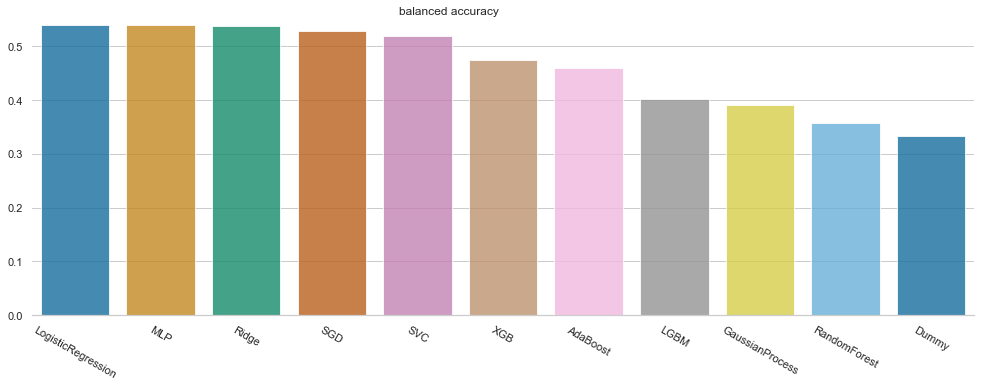

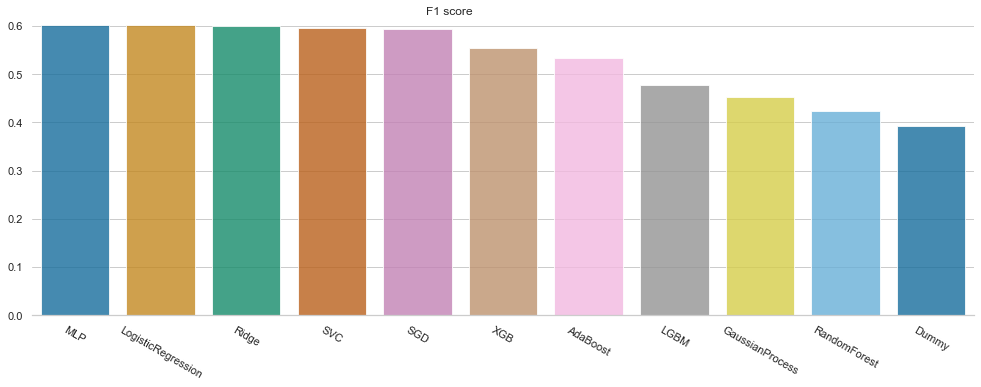

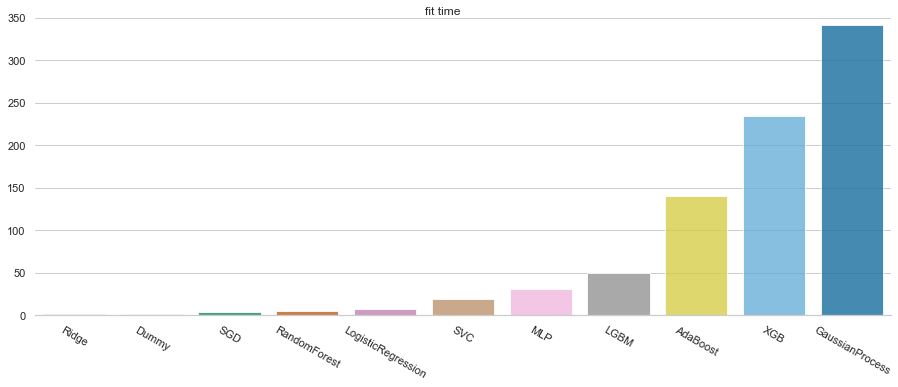

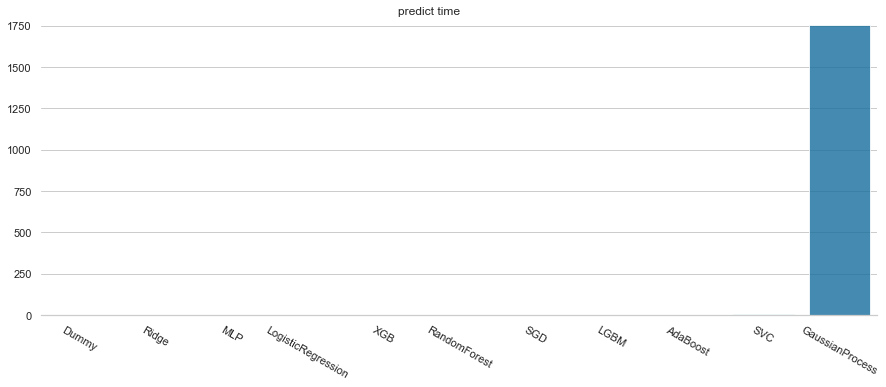

time: 1.82 s


In [24]:
for metric in tqdm(metrics):
    plot_metric(metric)

In [25]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/explore_OvO_results.csv")

time: 9 ms


# Discussion

These scores aren't great, but it's nice to see that all chosen models displayed skill relative to the dummy. Performance on the ternary multiclass, ternary OvR, and ternary OvO tasks are about the same.

I am happy to eliminate the Gaussian Process classifier from consideration; it is the slowest by far in training and inference and the third-worst performing model after Random Forest and the dummy.

The tree-based methods, in conjunction with the Gaussian Process classifier and the dummy, are the least performant models.

[^top](#Contents)